## Set up notebook

In [1]:
%env PYTHONHASHSEED=0
#import libaries
import numpy as np
from numpy.random import seed
import random as python_random
import tensorflow as tf

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(23)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
python_random.seed(23)

# The below set_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
tf.random.set_seed(23)

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers
from keras import backend as K
from keras import models

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, roc_auc_score
import itertools
from sklearn.metrics import confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score

env: PYTHONHASHSEED=0


Using TensorFlow backend.


In [2]:
#set up function for confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
#set up evaluation metric functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Image Preprocessing (rescale, resize, reshape)

In [4]:
#create directory to train, test, val data
test_folder = '../data_val/test'
train_folder = '../data_val/train'
val_folder = '../data_val/val'

In [5]:
#rescale and resize train, val, test data
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(224,224), batch_size=3636)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(224,224), batch_size = 247)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(224,224), batch_size = 390) 

Found 3636 images belonging to 2 classes.
Found 247 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


In [6]:
#split data to images and labels
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [7]:
#reshape data
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

train_y = np.reshape(train_labels[:,0], (3636,1))
test_y = np.reshape(test_labels[:,0], (390,1))
val_y = np.reshape(val_labels[:,0], (247,1))

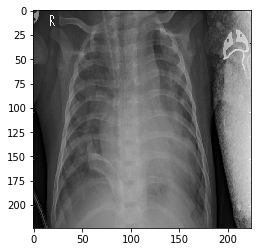

In [8]:
plt.imshow(train_images[123])

## Create model 

In [9]:
#build model
# seed(91)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
    ])

## Train model

In [12]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['acc', f1_m,precision_m, recall_m])
history = model.fit(train_images, train_y,
                    epochs=10, batch_size = 25, validation_data= (val_images, val_y), verbose = 1)

Train on 3636 samples, validate on 247 samples
Epoch 1/10
3636/3636 [==============================] - 114s 31ms/sample - loss: 0.5927 - acc: 0.7016 - val_loss: 0.8932 - val_acc: 0.4332
Epoch 2/10
3636/3636 [==============================] - 113s 31ms/sample - loss: 0.4977 - acc: 0.7660 - val_loss: 1.1586 - val_acc: 0.4656
Epoch 3/10
3636/3636 [==============================] - 112s 31ms/sample - loss: 0.4778 - acc: 0.7753 - val_loss: 1.0533 - val_acc: 0.3927
Epoch 4/10
3636/3636 [==============================] - 111s 31ms/sample - loss: 0.4617 - acc: 0.7781 - val_loss: 1.1067 - val_acc: 0.3644
Epoch 5/10
3636/3636 [==============================] - 112s 31ms/sample - loss: 0.4496 - acc: 0.7880 - val_loss: 1.0696 - val_acc: 0.4089
Epoch 6/10
3636/3636 [==============================] - 113s 31ms/sample - loss: 0.4181 - acc: 0.8025 - val_loss: 1.0333 - val_acc: 0.4413
Epoch 7/10
3636/3636 [==============================] - 112s 31ms/sample - loss: 0.3929 - acc: 0.8185 - val_loss: 1.122

## Evaluate model

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

In [15]:
results_train = model.evaluate(train_images, train_y)

3636/3636 [==============================] - 27s 8ms/sample - loss: 0.1566 - acc: 0.9373


In [16]:
results_train

[0.15662320821297052, 0.9372937]

In [17]:
results_val = model.evaluate(val_images,val_y)

247/247 [==============================] - 2s 7ms/sample - loss: 2.1537 - acc: 0.4494


In [18]:
results_val

[2.1537041094621667, 0.4493927]

In [19]:
model.save('Step02d_model.h5')

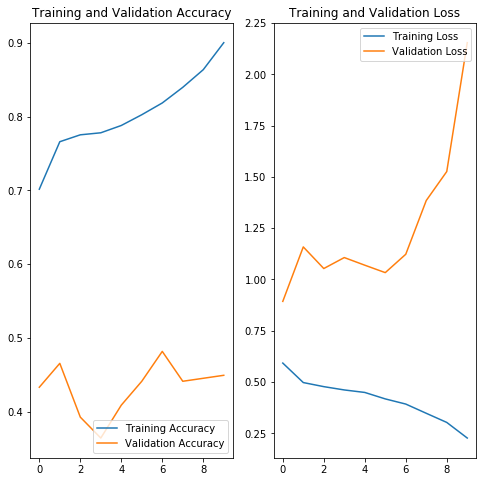

In [20]:
#Create a ROC curve
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix, without normalization
[[53 60]
 [76 58]]


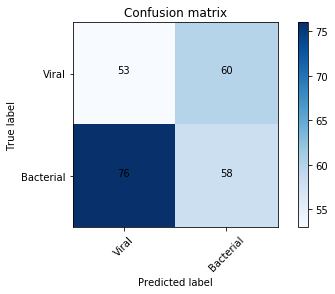

In [22]:
#Create a confusion matrix
y_pred = model.predict_classes(val_images)

cm = confusion_matrix(val_y, y_pred)
classes = ['Viral', 'Bacterial']
plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix')



## Create model 2

In [26]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(7, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2)])

## Train model 2

In [27]:
model2.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['acc'])
history2 = model2.fit(train_images, train_y,
                    epochs=5, batch_size = 25, validation_data= (val_images, val_y), verbose = 1)

Train on 3636 samples, validate on 247 samples
Epoch 1/5
3636/3636 [==============================] - 60s 16ms/sample - loss: 0.6144 - acc: 0.6900 - val_loss: 0.7525 - val_acc: 0.4980
Epoch 2/5
3636/3636 [==============================] - 59s 16ms/sample - loss: 0.5149 - acc: 0.7525 - val_loss: 0.9086 - val_acc: 0.4211
Epoch 3/5
3636/3636 [==============================] - 59s 16ms/sample - loss: 0.4847 - acc: 0.7742 - val_loss: 0.9604 - val_acc: 0.4615
Epoch 4/5
3636/3636 [==============================] - 59s 16ms/sample - loss: 0.4865 - acc: 0.7684 - val_loss: 0.9885 - val_acc: 0.4211
Epoch 5/5
3636/3636 [==============================] - 58s 16ms/sample - loss: 0.4705 - acc: 0.7789 - val_loss: 0.9988 - val_acc: 0.4049


## Evaluate model 2

In [28]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
dense_5 (Dense)              (None, 111, 111, 7)       231       
_________________________________________________________________
dense_6 (Dense)              (None, 111, 111, 5)       40        
_________________________________________________________________
flatten_2 (Flatten)          (None, 61605)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                

In [29]:
results_train2 = model2.evaluate(train_images, train_y)
results_train2

3636/3636 [==============================] - 14s 4ms/sample - loss: 0.4698 - acc: 0.7877


[0.46979875949480876, 0.7876788]

In [30]:
results_val = model.evaluate(val_images,val_y)
results_val

247/247 [==============================] - 2s 8ms/sample - loss: 2.1537 - acc: 0.4494


[2.1537041094621667, 0.4493927]

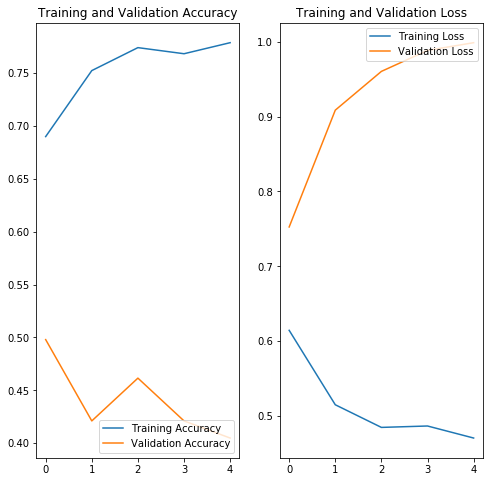

In [31]:
#Create a ROC curve
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix, without normalization
[[53 60]
 [76 58]]


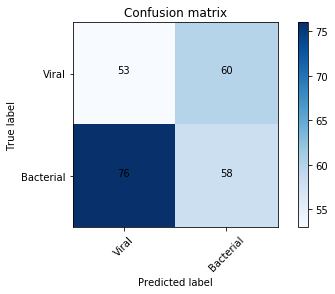

In [33]:
#Create a confusion matrix
y_pred = model2.predict_classes(val_images)

cm2 = confusion_matrix(val_y, y_pred)
classes = ['Viral', 'Bacterial']
plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix')

In [34]:
model2.save('Step02d_model2.h5')